# Backend Results

## Experiment 1 
- Seeing which algorithm converges faster given a particular unitary size and given resolution 
- Resolution ranges from [10,50] with a changed of 5 in between 
- Max iterations is 10 and error threshold is $10^{-3}$

In [38]:
resolutions = [i for i in range(10, 55, 5)]
resolutions

[10, 15, 20, 25, 30, 35, 40, 45, 50]

In [2]:
from qiskit import IBMQ
from qiskit import QuantumCircuit, execute, transpile, Aer
from qiskit.extensions import UnitaryGate, Initialize
from qiskit.quantum_info import Statevector
from qiskit.compiler import assemble 
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from time import sleep
import sys
import os
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
%matplotlib inline

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')
# santiago = provider.get_backend('ibmq_santiago')
# casablanca = provider.get_backend('ibmq_casablanca')
bogota = provider.get_backend('ibmq_bogota')
sim = Aer.get_backend('qasm_simulator')
# athens = provider.get_backend('ibmq_athens')

In [39]:
from normal_SPEA import SPEA
from changed_SPEA import global_max_SPEA

### Utils

In [4]:
def generate_plots(unitary_size, costs, errors, overlaps, algorithm):
    import random
    colors = ['red', 'brown', 'cyan', 'green',
              'grey', 'blue', 'purple', 'black', 'orange']
    c1, c2, c3 = random.sample(colors, 3)

    # plot
    os.makedirs("Experiment_1/"+str(unitary_size) +
                "_qubit(random)(backend)/", exist_ok=True)
    # plot 1
    fig = plt.figure(figsize=(13, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title(str(unitary_size)+" qubit "+algorithm +
                  " Cost v/s Max iters", fontsize=16)
    ax1.set_xlabel("Number of Resolutions ", fontsize=15)
    ax1.set_ylabel("Metrics Returned for unitary ", fontsize=15)
    ax1.plot(resolutions, costs, label='Costs of Unitary',
             marker='o', color=c1, alpha=0.7)
    ax1.plot(resolutions, overlaps, label='Average overlap from nearest eigenvector',
             marker='s', color=c2, alpha=0.6)
    ax1.legend(loc='best')
    ax1.grid()
    # plot 2
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title(str(unitary_size)+" qubit "+algorithm +
                  " % error v/s Max iters", fontsize=16)
    ax2.set_xlabel("Number of resolutions ", fontsize=15)
    ax2.set_ylabel("% error for nearest eigenvalue", fontsize=15)
    ax2.plot(resolutions, errors, label='Average error from nearest eigenvalue',
             marker='o', color=c3, alpha=0.6)
    ax2.legend(loc='best')
    ax2.grid()
    # save axure
    fig.savefig("Experiment_1/"+str(unitary_size)+"_qubit(random)(backend)/" +
                algorithm+" Algorithm (alternate).JPG", dpi=200)

In [40]:
def get_results(eig_vals, eig_vect, bases, basis_indices, unitary, algorithm, experiments):
    '''Return the results of running the algorithm for this particular unitary matrix'''
    costs_g = []
    errors_g = []
    max_overlaps_g = []
    # find how the cost converges with increasing iterations
    for reso in resolutions:
        costs = []
        errors = []
        overlaps = []
        i = 0
        # run the experiments ...
        while len(costs) < experiments:
            if algorithm == 'original':
                spea = SPEA(unitary, resolution=reso, error=3, max_iters=10)
            else:
                spea = global_max_SPEA(
                    unitary, resolution=reso, error=3, max_iters=10)

            result = spea.get_eigen_pair(
                progress=True, backend=bogota, algo='alternate', basis=bases[i], basis_ind=basis_indices[i],
                randomize=False,shots = 100)

            if result['cost'] < 0.65:
                continue
                
            # increment the basis index 
            i+=1  # in exp 1 -> basis[0], in exp 2 -> basis[1] and so on....
            
            # find the costs
            costs.append(result['cost'])
            theta = result['theta']
            res_state = result['state']

            # find the abs difference in this theta with the closest eigenvalue
            # and append that to the errors ...
            min_error = 1e5
            for e in eig_vals:
                error = abs(e - theta)
                if error < min_error:
                    min_error = error
                    perc_error = ((error)/e)*100
            errors.append(perc_error)

            # find overlaps
            max_overlap = -1
            for k in eig_vect:
                dot = np.linalg.norm(np.dot(k, res_state.conjugate().T))**2
                max_overlap = max(max_overlap, dot)
            overlaps.append(max_overlap)
        
        print("Result with", reso, " resolutions :")
        print("AVG. COST :", np.average(costs),
              "AVG. ERROR :", np.average(errors))
        # append the average result of your algorithm ...
        costs_g.append(np.average(costs))
        errors_g.append(np.average(errors))
        max_overlaps_g.append(np.average(overlaps))

    return costs_g, errors_g, max_overlaps_g

## 1 - qubit unitary

In [7]:
unit = unitary_group.rvs(2)
unit

array([[-0.62471762+0.34042653j, -0.69043234-0.13092309j],
       [-0.34361897+0.61299566j,  0.66238941-0.25962009j]])

In [8]:
eig_vals1, eig_vect1 = np.linalg.eig(unit)
eig_vals1 = np.angle(eig_vals1)
e = []
for k in eig_vals1:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals1 = np.array(e)
print("Eigenstates :", eig_vect1)
print("Eigenvalues :", eig_vals1)

Eigenstates : [[ 0.92486741+0.j         -0.30870283-0.22208745j]
 [ 0.30870283-0.22208745j  0.92486741+0.j        ]]
Eigenvalues : [0.42347272 0.93766709]


### Generate basis

In [9]:
sample1 = unitary_group.rvs(2)
print(sample1)
basis1 = []
for k in sample1:
    basis1.append(np.array(k,dtype=complex)) 
print("1 qubit basis :",basis1)
ind1 = np.random.choice(range(2))
print(ind1)

[[-0.77942541-0.28359166j  0.14803655-0.53866221j]
 [ 0.54542553-0.12075921j -0.2440345 -0.79270131j]]
1 qubit basis : [array([-0.77942541-0.28359166j,  0.14803655-0.53866221j]), array([ 0.54542553-0.12075921j, -0.2440345 -0.79270131j])]
1


### Algorithm 1

In [10]:
costs_1qubit_b, errors_eig_1qubit_b, max_overlaps_1qubit_b = get_results(
    eig_vals1, eig_vect1,basis1, ind1, unit, 'original', 4)

E:\ANACONDA\lib\site-packages\qiskit\circuit\quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 10  resolutions :
AVG. COST : 0.9521484375 AVG. ERROR : 4.790090055412168
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 15  resolutions :
AVG. COST : 0.9404296875 AVG. ERROR : 10.49110308524252
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the e

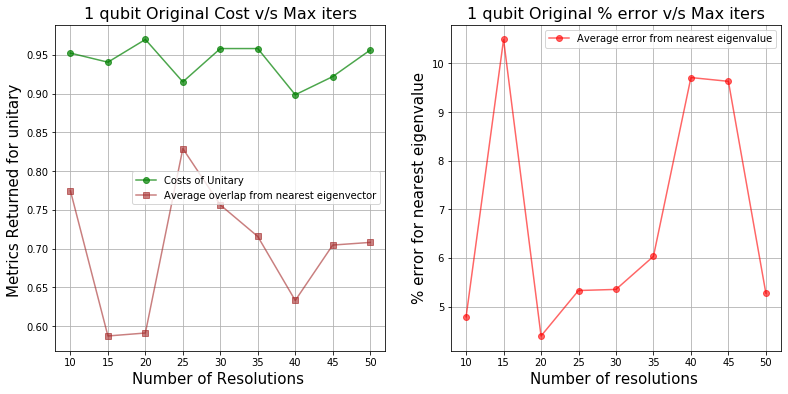

In [11]:
generate_plots(1, costs_1qubit_b, errors_eig_1qubit_b,
               max_overlaps_1qubit_b, "Original")

### Algorithm 2

PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 10  resolutions :
AVG. COST : 0.8720703125 AVG. ERROR : 15.889275196680606
PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [-0.66607896+0.2169937j   0.71331421+0.02086617j]
Maximum iterations reached for the estimation.
Terminating algorithm...
PHI : [-0.6660789

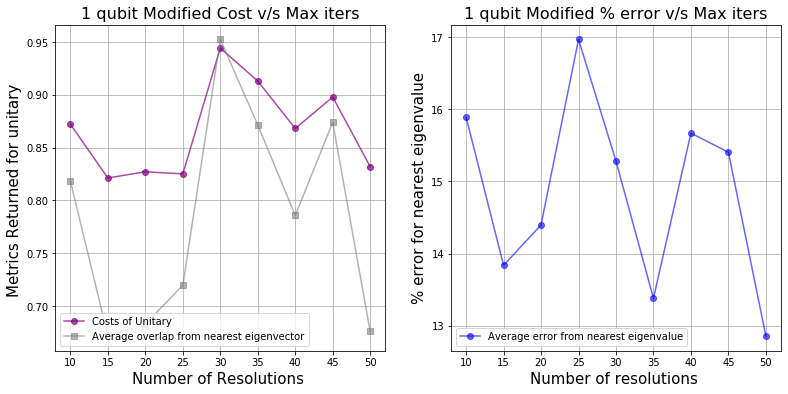

In [12]:
costs_1qubit_c, errors_eig_1qubit_c, max_overlaps_1qubit_c = get_results(
    eig_vals1, eig_vect1, basis1, ind1, unit, 'modified', 4)
generate_plots(1, costs_1qubit_c, errors_eig_1qubit_c,
               max_overlaps_1qubit_c, "Modified")

## 2 - qubit unitary


In [31]:
unit_2 = unitary_group.rvs(4)
unit_2

array([[ 0.64128444-0.27736156j, -0.21355809+0.21854152j,
         0.23946938+0.19745861j,  0.30178   -0.48067736j],
       [-0.11317086+0.04436548j,  0.36453237-0.3463647j ,
         0.55611796+0.64611926j, -0.07505975-0.00066654j],
       [-0.196014  -0.11549982j, -0.41082648+0.58832912j,
         0.30713363+0.25831961j,  0.01176351+0.52166108j],
       [-0.4948882 +0.44763028j, -0.32766562+0.17749894j,
         0.05216328+0.11465656j, -0.02059377-0.63210042j]])

In [32]:
eig_vals2, eig_vect2 = np.linalg.eig(unit_2)
eig_vals2 = np.angle(eig_vals2)
e = []
for k in eig_vals2:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals2 = np.array(e)
print("Eigenstates :", eig_vect2)
print("Eigenvalues :", eig_vals2)

Eigenstates : [[ 0.08544396-0.2421959j   0.80893871+0.j          0.09073626+0.40767462j
  -0.15496072-0.28498096j]
 [ 0.38634875-0.33867794j -0.13120938-0.27150226j  0.19183925+0.21991005j
   0.74829125+0.j        ]
 [ 0.77466302+0.j         -0.13200947-0.20986979j -0.15774393-0.23971361j
  -0.38837042-0.32441952j]
 [ 0.26324228+0.02594364j -0.07353868+0.43336939j  0.81120888+0.j
  -0.18779678+0.20853295j]]
Eigenvalues : [0.20346301 0.9792327  0.68402293 0.81817579]


### Generate Basis

In [33]:
bases2 , basis_indices2 = [], []
for _ in range(4):
    sample = unitary_group.rvs(4)
    basis = []
    for k in sample:
        basis.append(np.array(k, dtype=complex))
    ind = np.random.choice(range(4))
    bases2.append(basis)
    basis_indices2.append(ind)
print("Basis set :",bases2)
print("Basis indices :",basis_indices2)

Basis set : [[array([0.62758149-0.09971004j, 0.50394802-0.35377642j,
       0.13839627+0.24120543j, 0.32242457-0.18917408j]), array([-0.2468125 -0.41447911j,  0.12402781-0.15485477j,
       -0.66329034-0.07101779j,  0.47114812+0.24687974j]), array([ 0.29093434+0.32132061j, -0.10979761-0.23771932j,
       -0.640773  -0.23488195j, -0.34111497-0.40177767j]), array([ 0.07556358+0.41217771j, -0.39145357-0.5997615j ,
        0.10898814-0.00555179j,  0.19218373+0.51245108j])], [array([-0.45302394+0.16516235j, -0.49563561+0.59702568j,
       -0.03974591+0.09628647j,  0.03567509-0.39150077j]), array([ 0.10286469+0.64292877j, -0.130088  -0.52762658j,
        0.04429638-0.09528871j, -0.03052838-0.51843482j]), array([-0.30428076+0.36576749j, -0.10901156-0.14774826j,
       -0.63477661+0.16225862j, -0.24372719+0.50124061j]), array([ 0.1777232 +0.29256448j, -0.10944321+0.2385416j ,
       -0.08005448-0.7364979j ,  0.42808046+0.28609408j])], [array([ 0.14769898-0.10832429j, -0.35362803-0.08783615j,
 


### Algorithm 1

Result with 10  resolutions :
AVG. COST : 1.0 AVG. ERROR : 72.87245837460236
Result with 15  resolutions :
AVG. COST : 1.0 AVG. ERROR : 85.1064166784578
Result with 20  resolutions :
AVG. COST : 1.0 AVG. ERROR : 29.20272752648259
Result with 25  resolutions :
AVG. COST : 1.0 AVG. ERROR : 32.73340321408235
Result with 30  resolutions :
AVG. COST : 1.0 AVG. ERROR : 47.45057043502945
Result with 35  resolutions :
AVG. COST : 1.0 AVG. ERROR : 69.25856254005522
Result with 40  resolutions :
AVG. COST : 1.0 AVG. ERROR : 81.50575855759034
Result with 45  resolutions :
AVG. COST : 1.0 AVG. ERROR : 48.74709983546776
Result with 50  resolutions :
AVG. COST : 1.0 AVG. ERROR : 57.67482740032355


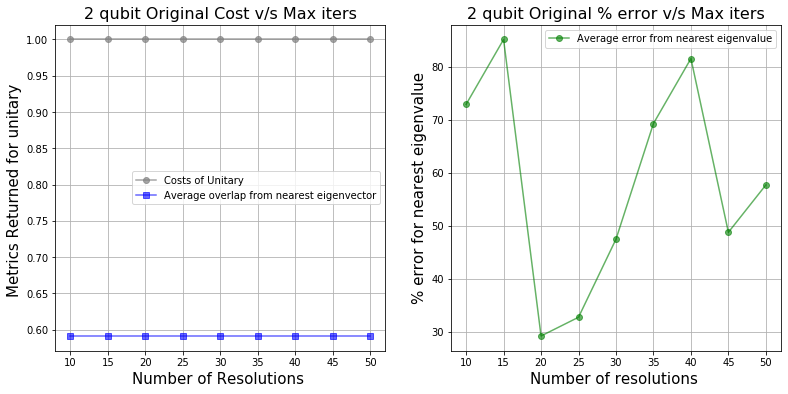

In [36]:
costs_2qubit_b, errors_eig_2qubit_b, max_overlaps_2qubit_b = get_results(
    eig_vals2, eig_vect2, bases2, basis_indices2, unit_2, 'original', 4)
generate_plots(2, costs_2qubit_b, errors_eig_2qubit_b,
               max_overlaps_2qubit_b, "Original")

### Algorithm 2

In [41]:
costs_2qubit_c, errors_eig_2qubit_c, max_overlaps_2qubit_c = get_results(
    eig_vals2, eig_vect2, bases2, basis_indices2, unit_2, 'modified', 4)
generate_plots(2, costs_2qubit_c, errors_eig_2qubit_c,
               max_overlaps_2qubit_c, "Modified")

Right : 0.4722222222222222
Left : 0
ITERATION NUMBER 1 ...
100.000000 %completedBest Phi is : [-0.41301745-0.32879845j  0.39410876-0.32225628j -0.58099483-0.01070334j
  0.1710752 +0.30854671j]
Theta estimate : 0.2623456790123457
Current cost : 0.65

COST : 0.65
THETA : 0.2623456790123457
Right : 0.3873456790123457
Left : 0.13734567901234568
ITERATION NUMBER 2 ...
62.500000 %completed

KeyboardInterrupt: 

## 3 - qubit unitary

In [30]:
unit_3 = unitary_group.rvs(8)
unit_3

array([[ 0.47777076+0.28744312j, -0.0978045 -0.15320067j,
         0.13612682+0.0864557j , -0.03736529+0.2514528j ,
        -0.25996035+0.13701622j, -0.01729151-0.19314694j,
         0.57124389-0.23013807j, -0.24015576+0.06730639j],
       [-0.24982007+0.18985901j, -0.29648411+0.33442437j,
        -0.01749636-0.32996174j,  0.0078571 +0.03297437j,
        -0.28139132+0.25388971j, -0.07124761-0.22941164j,
        -0.01467723-0.20734504j,  0.18875472-0.55793222j],
       [ 0.07661344+0.24430515j, -0.20256713-0.34316937j,
        -0.34066301+0.13476242j, -0.04082704+0.26946289j,
         0.03987111+0.49588304j,  0.09161999+0.38256955j,
        -0.16109137+0.08185655j,  0.36243341+0.03008545j],
       [ 0.27885805+0.1969512j , -0.17033557+0.35968426j,
         0.0498281 +0.24817352j,  0.0493131 -0.30113444j,
        -0.41678435+0.10693985j,  0.08275623-0.20503826j,
        -0.36530597+0.25532326j,  0.08293441+0.35822289j],
       [-0.283094  -0.04715866j, -0.13192598-0.43004184j,
         0

In [31]:
eig_vals3, eig_vect3 = np.linalg.eig(unit_3)
eig_vals3 = np.angle(eig_vals3)
e = []
for k in eig_vals3:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals3 = np.array(e)
print("Eigenstates :", eig_vect3)
print("Eigenvalues :", eig_vals3)

Eigenstates : [[ 0.61383813+0.j         -0.05814477-0.0219199j  -0.48884258+0.14236145j
   0.35560747-0.02725232j -0.32207746-0.08606266j -0.22032611+0.09721024j
  -0.01625627+0.14114773j  0.15778119+0.13671975j]
 [-0.05939596+0.01424378j -0.24210878-0.12830284j  0.05039442-0.04712949j
  -0.27036254+0.45830427j -0.38027242+0.2196691j   0.28520362-0.02704217j
  -0.13127943+0.2614482j   0.52227196+0.j        ]
 [-0.15820829+0.21012125j -0.29290809-0.1499455j  -0.11348121+0.2916986j
   0.22640011-0.10439686j  0.08206877-0.29053108j  0.24326372+0.18791235j
  -0.48503921-0.20477788j  0.0891726 -0.43776474j]
 [-0.02213749+0.15820307j  0.66464403+0.j         -0.06543522+0.39850294j
  -0.02677328+0.11679707j -0.27454238-0.10827627j  0.20278597-0.38232757j
   0.09651847-0.21383846j  0.07361673-0.14293146j]
 [-0.11243913+0.00466734j  0.02731213+0.32021865j  0.52459085+0.j
   0.5545346 +0.j         -0.09992331-0.1287409j  -0.03041687-0.02758373j
  -0.13155064-0.10637676j  0.33161842+0.36675365j]


### Generate Basis

In [32]:
bases3 , basis_indices3 = [], []
for _ in range(4):
    sample = unitary_group.rvs(8)
    basis = []
    for k in sample:
        basis.append(np.array(k, dtype=complex))
    ind = np.random.choice(range(8))
    bases3.append(basis)
    basis_indices3.append(ind)
print("Basis set :",bases3)
print("Basis indices :",basis_indices3)

3 qubit basis : [array([-0.35642039-0.39285719j, -0.16882515-0.12782415j,
       -0.32910459+0.13664071j, -0.0836015 -0.5560188j ,
        0.11203368+0.13402969j,  0.13374111-0.26698073j,
       -0.05998458+0.12740123j,  0.12930587-0.27281868j]), array([-0.22201624-0.34055959j,  0.30605811+0.34289436j,
        0.29691294+0.29514723j,  0.14742677+0.00747977j,
        0.33486755-0.12738825j,  0.16266994+0.16735587j,
        0.36953886-0.23690994j,  0.21706006+0.06153182j]), array([ 0.25625475-0.10910933j,  0.09674866+0.09539155j,
       -0.02270754+0.20832235j, -0.414973  -0.20769383j,
       -0.5685212 +0.13981601j, -0.15465682+0.00100845j,
        0.09018049-0.44825798j,  0.25755107+0.05129084j]), array([ 0.31590005-0.13243755j,  0.09983574-0.34858129j,
        0.25518999+0.3927277j , -0.02595457+0.11005796j,
        0.04447716-0.35553958j, -0.21024736-0.21380621j,
       -0.12571217+0.37434026j,  0.35926376-0.125458j  ]), array([ 0.31726   +0.06699767j, -0.1500964 +0.45519937j,
      

- Algorithm 1

In [ ]:
costs_3qubit_b, errors_eig_3qubit_b, max_overlaps_3qubit_b = get_results(
    eig_vals3, eig_vect3, bases3, basis_indices3, unit_3, 'original', 4)

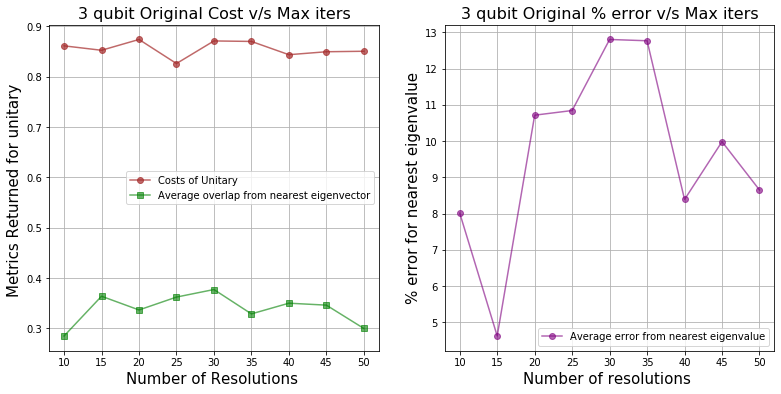

In [34]:
generate_plots(3, costs_3qubit_b, errors_eig_3qubit_b,
               max_overlaps_3qubit_b, "Original")

- Algorithm 2

In [ ]:
costs_3qubit_c, errors_eig_3qubit_c, max_overlaps_3qubit_c = get_results(
    eig_vals3, eig_vect3, bases3, basis_indices3, unit_3, 'modified', 4)
generate_plots(3, costs_3qubit_c, errors_eig_3qubit_c,
               max_overlaps_3qubit_c, "Modified")

## 4 - qubit unitary

In [ ]:
unit_4 = unitary_group.rvs(16)
unit_4

In [ ]:
eig_vals4, eig_vect4 = np.linalg.eig(unit_4)
eig_vals4 = np.angle(eig_vals4)
e = []
for k in eig_vals4:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals4 = np.array(e)
print("Eigenstates :", eig_vect4)
print("Eigenvalues :", eig_vals4)

### Generate Basis set

In [ ]:
bases4 , basis_indices4 = [], []
for _ in range(4):
    sample = unitary_group.rvs(16)
    basis = []
    for k in sample:
        basis.append(np.array(k, dtype=complex))
    ind = np.random.choice(range(16))
    bases4.append(basis)
    basis_indices4.append(ind)
print("Basis set :",bases4)
print("Basis indices :",basis_indices4)

- Algorithm 1

In [ ]:
costs_4qubit_b, errors_eig_4qubit_b, max_overlaps_4qubit_b = get_results(
    eig_vals4, eig_vect4, bases4, basis_indices4, unit_4, 'original', 4)
generate_plots(4, costs_4qubit_b, errors_eig_4qubit_b,
               max_overlaps_4qubit_b, "Original")

- Algorithm 2

In [ ]:
costs_4qubit_b, errors_eig_4qubit_b, max_overlaps_4qubit_b = get_results(
    eig_vals4, eig_vect4, bases4, basis_indices4, unit_4, 'modified', 4)
generate_plots(4, costs_4qubit_b, errors_eig_4qubit_b,
               max_overlaps_4qubit_b, "Modified")